In [ ]:
#QUESTIONS:
#Do revenue and seller density (=count) correspond with what we know about economical prosperity of 5 key regions in Brazil?
#How does this trend over time?
#When it comes to order processing, how do buckets look like?


In [11]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [3]:
#Let's think about metrics that can describe how good our sellers perform. When it comes to order processing it is time to approve (TTA) the order.
#The dataset contains the timestamps for when the order was placed and when it was accepted by the seller. The time taken by the seller to accept the order is classified into these categories:
# Less than 1 hour -> Instant
# 1 hour to 5 hours -> Fast
# 5 hours to 12 hours -> Average
# 12 hours to 24 hours -> Slow
# More than 24 hours -> Slowest

In [3]:
%%sql
#1612081119e8f23745698ad3367cc14b - anomaly order with more than 4500 hrs TTA
WITH tta_calc AS (
    SELECT
        order_id,
        DATE_DIFF(order_approved_at, order_purchase_timestamp, HOUR) AS TTA
    FROM my-project-trial-388315.olist_kaggle.orders
    WHERE order_id != '1612081119e8f23745698ad3367cc14b'
),
     tta_segments AS (
         SELECT *
         FROM tta_calc
                  JOIN my-project-trial-388315.olist_kaggle.items AS items ON tta_calc.order_id = items.order_id
                  JOIN my-project-trial-388315.olist_kaggle.olist_sellers os ON items.seller_id = os.seller_id
     )
SELECT
    COUNT(CASE WHEN tta_segments.TTA < 1 THEN 1 END) AS Instant,
    COUNT(CASE WHEN tta_segments.TTA BETWEEN 1 AND 5 THEN 1 END) AS Fast,
    COUNT(CASE WHEN tta_segments.TTA BETWEEN 5 AND 12 THEN 1 END) AS Average,
    COUNT(CASE WHEN tta_segments.TTA BETWEEN 12 AND 24 THEN 1 END) AS Slow,
    COUNT(CASE WHEN tta_segments.TTA > 24 THEN 1 END) AS Slowest
FROM tta_segments;

,Instant,Fast,Average,Slow,Slowest
0,71246,6894,4622,13633,17477


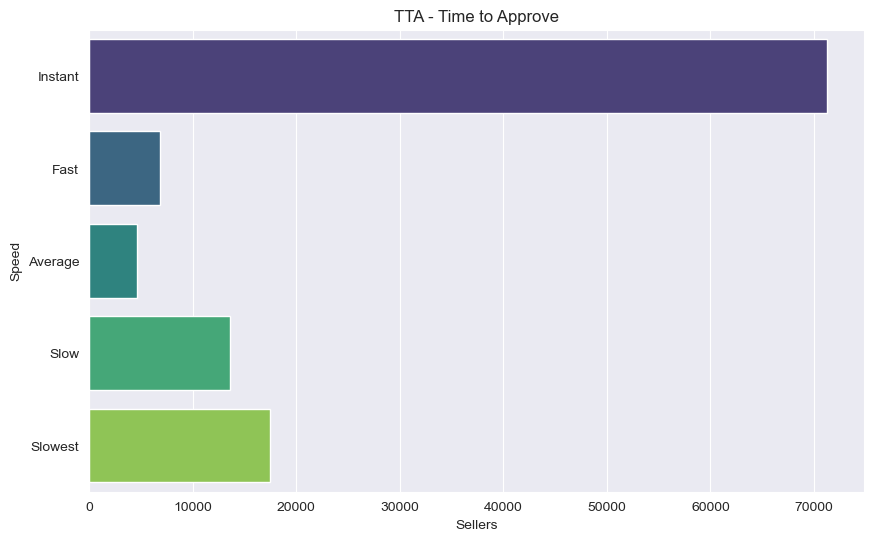

In [16]:
df = pd.DataFrame(tta_calc)

# Transpose the DataFrame and reset index
df = df.T.reset_index()
df.columns = ['TTA - Time to Approve', 'Sellers']

# Calculate total count
total_count = df['Sellers'].sum()

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=df, x='Sellers', y='TTA - Time to Approve', palette='viridis')


plt.xlabel('Sellers')
plt.ylabel('Speed')
plt.title('TTA - Time to Approve')
plt.show()


In order to see how revenue is distributed across key Brazil regions we group 23 states into the following regions:
North (poorest) = Acre ['AC'], Amapá ['AM'], Amazonas, Pará ['PA'], Rondônia, Roraima ['RO'] and Tocantins. 
Southeast (richest) = Espírito Santo ['ES'], Minas Gerais ['MS'],Rio de Janeiro ['RJ'] and São Paulo ['SP'], 
Central-West = Goiás ['GO'],Mato Grosso ['MG'] and Mato Grosso do Sul ['MT']; Distrito Federal ['DF'], 
Northeast Region = Maranhão ['MA']], Piauí ['PI'], Ceará ['CE'], Rio Grande do Norte ['RN'], Paraíba ['PB'],Pernambuco ['PE'], Alagoas, Sergipe ['SE'] and Bahia ['BA'] along with the Fernando de Noronha South (smallest) = Paraná ['PR'], Rio Grande do Sul ['RS'] and Santa Catarina ['SC'].

In [17]:
%%sql
SELECT os.seller_id,
       CASE
           WHEN os.seller_state IN ('PI','MA','CE','RN','PB','PE','SE', 'BA') THEN 'NorthEast'
           WHEN os.seller_state IN ('PR', 'RS', 'SC') THEN 'South'
           WHEN os.seller_state IN ('GO','MG','MT','DF') THEN 'Central-West'
           WHEN os.seller_state IN ('ES','MS','RJ','SP') THEN 'Southest'
           WHEN os.seller_state IN ('AC','AM','PA','RO') THEN 'North'
       END AS regions
FROM my-project-trial-388315.olist_kaggle.items AS items
         JOIN my-project-trial-388315.olist_kaggle.olist_sellers os
         ON items.seller_id = os.seller_id

,seller_id,regions
0,b64d51f0435e884e8de603b1655155ae,Southest
1,b64d51f0435e884e8de603b1655155ae,Southest
2,cf6f6bc4df3999b9c6440f124fb2f687,Southest
3,ce616e1913288884e7742faac9d981db,Southest
4,ce616e1913288884e7742faac9d981db,Southest
...,...,...
112645,3c03b12bab54d8b37d79d914bfdb1aa0,Southest
112646,3c03b12bab54d8b37d79d914bfdb1aa0,Southest
112647,3c03b12bab54d8b37d79d914bfdb1aa0,Southest
112648,3c03b12bab54d8b37d79d914bfdb1aa0,Southest


<Axes: xlabel='regions', ylabel='count'>

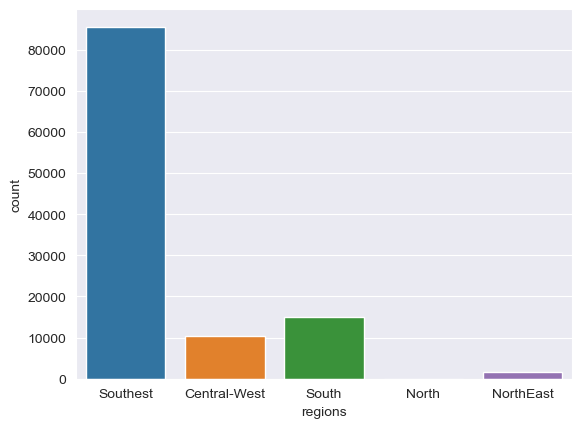

In [19]:
%%sql
WITH reg_map as (SELECT os.seller_id,
       items.price,
       items.freight_value,
       CASE
           WHEN os.seller_state IN ('PI','MA','CE','RN','PB','PE','SE', 'BA') THEN 'NorthEast'
           WHEN os.seller_state IN ('PR', 'RS', 'SC') THEN 'South'
           WHEN os.seller_state IN ('GO','MG','MT','DF') THEN 'Central-West'
           WHEN os.seller_state IN ('ES','MS','RJ','SP') THEN 'Southeast'
           WHEN os.seller_state IN ('AC','AM','PA','RO') THEN 'North'
       END AS regions
FROM my-project-trial-388315.olist_kaggle.items AS items
         JOIN my-project-trial-388315.olist_kaggle.olist_sellers os
         ON items.seller_id = os.seller_id)
SELECT ROUND(SUM (reg_map.price+reg_map.freight_value)) as revenue,
       reg_map.regions
FROM reg_map
GROUP BY reg_map.regions

,revenue,regions
0,11243309,Southest
1,1441070,Central-West
2,2633676,South
3,8427,North
4,517070,NorthEast


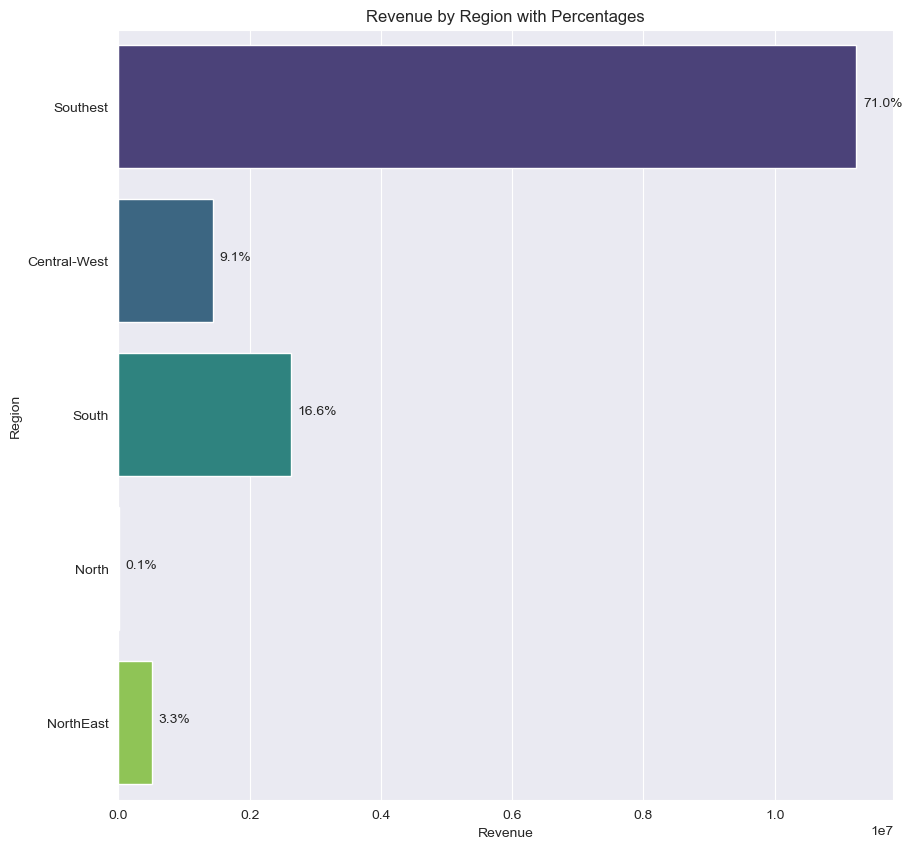

In [25]:
# Plot
plt.figure(figsize=(10, 10))
ax = sns.barplot(data=df_sql4, x='revenue', y='regions', palette='viridis')

# Add percentages to the bars
total_revenue = df_sql4['revenue'].sum()
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_width() / total_revenue)
    x = p.get_width() + 100000  # adjust position for better visibility
    y = p.get_y() + p.get_height() / 2
    ax.annotate(percentage, (x, y), ha='left')

plt.xlabel('Revenue')
plt.ylabel('Region')
plt.title('Revenue by Region with Percentages')
plt.show()



In [26]:
%%sql
WITH reg_map as (SELECT os.seller_id,
                        items.price,
                        items.freight_value,
                        DATE_TRUNC(orders.order_purchase_timestamp,MONTH) as purchase_date,
                        CASE
                            WHEN os.seller_state IN ('PI','MA','CE','RN','PB','PE','SE', 'BA') THEN 'NorthEast'
                            WHEN os.seller_state IN ('PR', 'RS', 'SC') THEN 'South'
                            WHEN os.seller_state IN ('GO','MG','MT','DF') THEN 'Central-West'
                            WHEN os.seller_state IN ('ES','MS','RJ','SP') THEN 'Southest'
                            WHEN os.seller_state IN ('AC','AM','PA','RO') THEN 'North'
                            END AS regions
                 FROM my-project-trial-388315.olist_kaggle.items AS items
                          JOIN my-project-trial-388315.olist_kaggle.olist_sellers os
                               ON items.seller_id = os.seller_id
                          JOIN my-project-trial-388315.olist_kaggle.orders orders
                               ON orders.order_id = items.order_id )
SELECT ROUND(SUM (reg_map.price+reg_map.freight_value)) as revenue,
       reg_map.regions,
       reg_map.purchase_date
FROM reg_map
GROUP BY reg_map.regions, reg_map.purchase_date

,revenue,regions,purchase_date
0,716453,Southest,2018-07-01 00:00:00.000000
1,712410,Southest,2018-08-01 00:00:00.000000
2,415965,Southest,2017-05-01 00:00:00.000000
3,718647,Southest,2018-06-01 00:00:00.000000
4,532352,Southest,2017-10-01 00:00:00.000000
...,...,...,...
96,822,North,2017-08-01 00:00:00.000000
97,103,North,2018-03-01 00:00:00.000000
98,267,NorthEast,2016-10-01 00:00:00.000000
99,355,North,2017-04-01 00:00:00.000000


/opt/miniconda3/envs/viz_pack/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/viz_pack/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/miniconda3/envs/viz_pack/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/opt/miniconda3/envs/viz_pack/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When gr

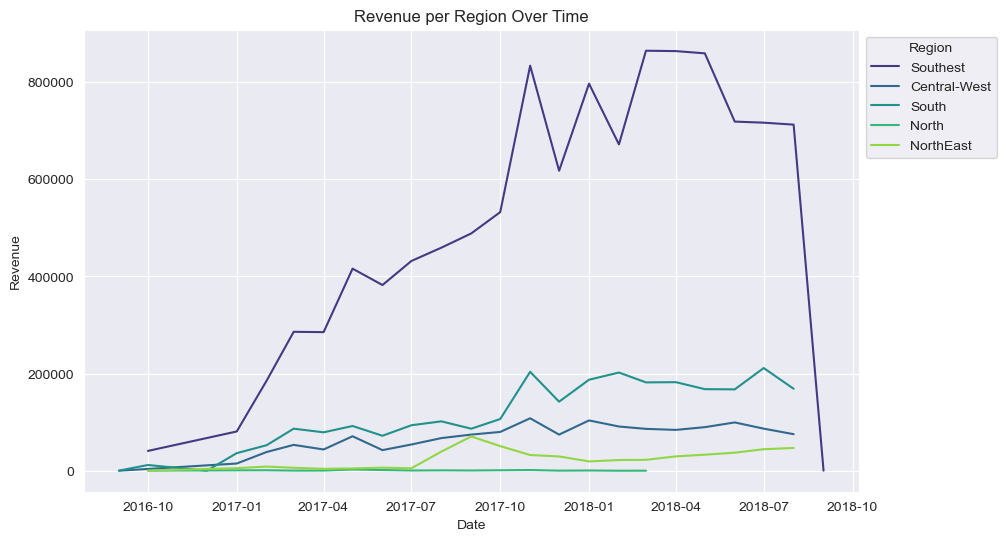

In [27]:
# Convert 'purchase_date' to datetime
df_sql5['purchase_date'] = pd.to_datetime(df_sql5['purchase_date'])

# Set 'purchase_date' as index
df_sql5.set_index('purchase_date', inplace=True)

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=df_sql5, x=df_sql5.index, y='revenue', hue='regions', palette='viridis')

plt.xlabel('Date')
plt.ylabel('Revenue')
plt.title('Revenue per Region Over Time')
plt.legend(title='Region', bbox_to_anchor=(1, 1), loc='upper left')
plt.show()


In [1]:
%%sql
#% of customers who place orders with different sellers (more than 1 unique seller)
SELECT cust_id, COUNT(DISTINCT sel_id) AS different_sellers_count
FROM
(SELECT orders.customer_id AS cust_id,
       items.seller_id AS sel_id,
       items.order_id AS ord_id,
       orders.order_purchase_timestamp,
       COUNT(DISTINCT items.seller_id) AS seller_count
FROM my-project-trial-388315.olist_kaggle.items AS items
         JOIN my-project-trial-388315.olist_kaggle.orders AS orders
              ON items.order_id = orders.order_id
         JOIN my-project-trial-388315.olist_kaggle.customers AS customers
              ON orders.customer_id = customers.customer_id
GROUP BY orders.customer_id, items.order_id, orders.order_purchase_timestamp, items.seller_id) AS order_summary
 GROUP BY cust_id
 HAVING COUNT(*) > 1;

,cust_id,different_sellers_count
0,ddedd0a8c9f0acc02d3bc02070d117f7,2
1,7b962215806a3c1e6bdb02a9489ec486,2
2,730769d8a5103f14d741ad1706e1c352,2
3,5f50465da00b7fed5dd1239f4ecf6e2c,2
4,8dab637615e9eae6d33ef5e48644d6d3,2
...,...,...
1273,2f1a3baba1b833c18c5da7b721b360b2,2
1274,85df45704acdf1ff318576830a282d19,2
1275,ba9f01f047473c3db12adbf0b68cdaa9,2
1276,2ce72245ffebb0287ae4193d34128753,2


In [ ]:
#% of customers who place orders with different sellers (more than 1 unique seller)

In [2]:
%%sql
SELECT DISTINCT (orders.customer_id)
FROM my-project-trial-388315.olist_kaggle.orders

,customer_id
0,725e9c75605414b21fd8c8d5a1c2f1d6
1,4ee64f4bfc542546f422da0aeb462853
2,438449d4af8980d107bf04571413a8e7
3,964a6df3d9bdf60fe3e7b8bb69ed893a
4,7d61b9f4f216052ba664f22e9c504ef1
...,...
99436,9ad3cb19919815536d4ae2c46d69279c
99437,cef54c3ad569af033c4ecdaa69c9e140
99438,921e7175793c295e163d9bd7c8b1c1ee
99439,8feae4bd81cd90e377f43588b900d3c2


In [14]:
unique_customer_count = df_sql7.shape[0]
non_monogamous_customers = len(df_sql6)
non_monogamous_transactions_perc=(non_monogamous_customers/unique_customer_count)*100
print(non_monogamous_transactions_perc)

1.2851841795637613


In [18]:
%%sql
SELECT DISTINCT (sellers.seller_id)
FROM my-project-trial-388315.olist_kaggle.olist_sellers as sellers

,seller_id
0,4be2e7f96b4fd749d52dff41f80e39dd
1,327b89b872c14d1c0be7235ef4871685
2,4221a7df464f1fe2955934e30ff3a5a1
3,651530bf5c607240ccdd89a30c9c9712
4,2b402d5dc42554061f8ea98d1916f148
...,...
3090,de0c78824586e9a5f5f04fd84e25df39
3091,a1bea7061f61f6fdd9a85a6325ba1033
3092,f626e15b7314c267e4429010866f70e9
3093,6a3139c7bf09ece22a4713d956acbe5e


In [23]:
cust_to_seller_ratio = df_sql7.shape[0]/df_sql9.shape[0]
print(cust_to_seller_ratio)

32.12956381260097


In [9]:
%%sql
SELECT cust_id,
       COUNT(DISTINCT sel_id) AS different_sellers_count,
       TIMESTAMP_TRUNC(order_purchase_timestamp, MONTH ) AS purchase_date
FROM
(SELECT orders.customer_id AS cust_id,
       items.seller_id AS sel_id,
       items.order_id AS ord_id,
       orders.order_purchase_timestamp,
       COUNT(DISTINCT items.seller_id) AS seller_count
FROM my-project-trial-388315.olist_kaggle.items AS items
         JOIN my-project-trial-388315.olist_kaggle.orders AS orders
              ON items.order_id = orders.order_id
         JOIN my-project-trial-388315.olist_kaggle.customers AS customers
              ON orders.customer_id = customers.customer_id
GROUP BY orders.customer_id, items.order_id, orders.order_purchase_timestamp, items.seller_id) AS order_summary
 GROUP BY cust_id, purchase_date
 HAVING COUNT(*) > 1

,cust_id,different_sellers_count,purchase_date
0,6e9fcf097dd6735e0b0462052b83e936,2,2017-08-01 00:00:00.000000
1,3563b65918969aa4770325856ec0c256,2,2018-04-01 00:00:00.000000
2,0b6c2ee27dbe0bcbffd424f2ddedd222,2,2018-01-01 00:00:00.000000
3,72a366446dd3abfc90c598896714d85c,2,2018-08-01 00:00:00.000000
4,0f4f8f1c93fa4e87b000dde5ce03ffdd,2,2017-04-01 00:00:00.000000
...,...,...,...
1273,1173a4bd917d4e1a64917dd9851ccea9,2,2017-11-01 00:00:00.000000
1274,66c004ff369bf0244761de86fd2c687c,2,2018-01-01 00:00:00.000000
1275,99591752fa0fde84c1d12934abf94ca1,2,2017-08-01 00:00:00.000000
1276,b7ae8ccf4db05cfdefe709e22ccce819,2,2018-03-01 00:00:00.000000


In [19]:
%%sql
# Seller presense for top-performing product categories
SELECT
        string_field_1 AS product_category_name,
        COUNT(items.seller_id) as sellers
    FROM
        my-project-trial-388315.olist_kaggle.items items
            INNER JOIN
        my-project-trial-388315.olist_kaggle.products products
        ON
            items.product_id = products.product_id
            INNER JOIN my-project-trial-388315.olist_kaggle.product_category_name_translation translations
    ON products.product_category_name = translations.string_field_0
    GROUP BY product_category_name
    ORDER BY 2 DESC
    LIMIT 16

,product_category_name,sellers
0,bed_bath_table,11115
1,health_beauty,9670
2,sports_leisure,8641
3,furniture_decor,8334
4,computers_accessories,7827
5,housewares,6964
6,watches_gifts,5991
7,telephony,4545
8,garden_tools,4347
9,auto,4235


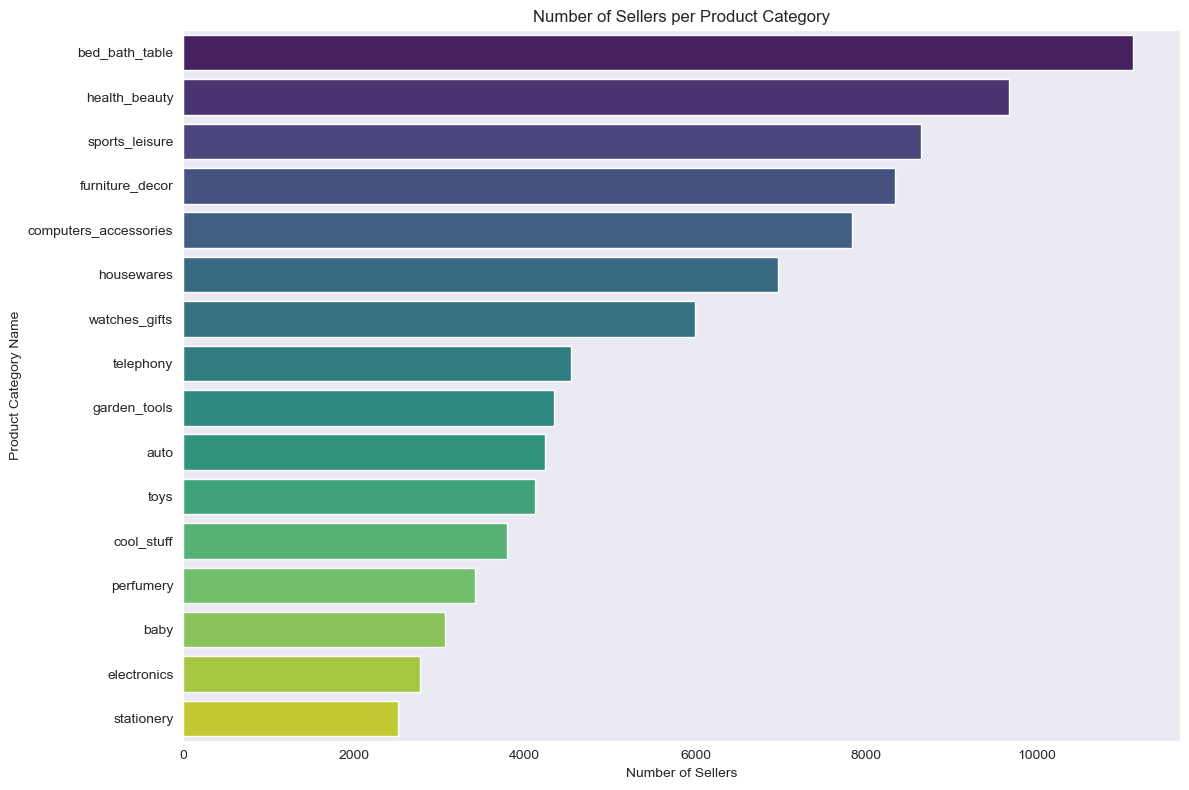

In [24]:
plt.figure(figsize=(12, 8))
sns.barplot(x='sellers', y='product_category_name', data=df_sql10, palette='viridis')
plt.title('Number of Sellers per Product Category')
plt.xlabel('Number of Sellers')
plt.ylabel('Product Category Name')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

In [20]:
%%sql
# Seller presense for worst-performing product categories
SELECT
        string_field_1 AS product_category_name,
        COUNT(items.seller_id) as sellers
    FROM
        my-project-trial-388315.olist_kaggle.items items
            INNER JOIN
        my-project-trial-388315.olist_kaggle.products products
        ON
            items.product_id = products.product_id
            INNER JOIN my-project-trial-388315.olist_kaggle.product_category_name_translation translations
    ON products.product_category_name = translations.string_field_0
    GROUP BY product_category_name
    ORDER BY 2 
    LIMIT 16

,product_category_name,sellers
0,security_and_services,2
1,fashion_childrens_clothes,8
2,la_cuisine,14
3,cds_dvds_musicals,14
4,arts_and_craftmanship,24
5,fashion_sport,30
6,home_comfort_2,30
7,flowers,33
8,music,38
9,furniture_mattress_and_upholstery,38


In [ ]:
#CONCLUSIONS
# We know that SouthEast is the richest region in Brazil and with 71% of revenue generated and 76% of sellers concentrated there, this is also reflected in our marketplace dynamic. North being the poorest and least inhabited region brings just 0.1% in terms of revenue.
#When it comes to order processing, overall dynamic is healthy, "Instant"(= under 1 hour) TTA being the biggest category of sellers.


# percentage for non-monogamous tra